In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch as pt
import numpy as np
from tqdm import tqdm
import seaborn as sns

tqdm.pandas()
from allocineutil import get_rating_class, get_rating_value
from transformers import CamembertTokenizerFast
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

Votre accuracy (3 classes) est de : 0.67703006511585
Votre accuracy (10 classes) est de : 0.18585390287372
F1-Mesure (5.0) : 0.030275229357798
F1-Mesure (4.5) : 0
F1-Mesure (4.0) : 0.31727381967196
F1-Mesure (3.5) : 0
F1-Mesure (3.0) : 0.037026488180006
F1-Mesure (2.5) : 0
F1-Mesure (2.0) : 0.01043617875301
F1-Mesure (1.5) : 0
F1-Mesure (1.0) : 0.018915510718789
F1-Mesure (0.5) : 0

In [2]:
train = pd.read_pickle("dataset/train.bin.zst")
test = pd.read_pickle("dataset/test.bin.zst")
dev = pd.read_pickle("dataset/dev.bin.zst")

In [3]:

# read ouputfile.txt

outputfile = pd.read_csv("outputfile.csv")
# outputfile.columns = ["id", "pred"]
outputfile.drop(columns=["Unnamed: 0"], inplace=True)
outputfile.set_index("id", inplace=True)
outputfile

,review_id,note
id,,
57113853,review_57113853,5.0
53044607,review_53044607,3.0
60265420,review_60265420,4.0
55880325,review_55880325,1.5
53015074,review_53015074,4.5
...,...,...
59620693,review_59620693,3.0
47495619,review_47495619,2.0
45417182,review_45417182,3.5


In [4]:
devGood = pd.read_pickle("devGood.bin.zst")
devbad = pd.read_pickle("devbad.bin.zst")

In [5]:
train

,movie,name,user_id,note,commentaire
review_id,,,,,
58145147,229864,AM11,Z20051105131449940367618,4.0,"""Ce n'est pas ce qui se trouve en face de vous..."
59303833,229864,this is my movies,Z20051220181957240298347,3.5,"(...) En soi, je n'ai rien contre ce genre de ..."
61916672,229864,Shephard69,Z20121226180301760912584,4.5,"Pour sa troisième réalisation après ""Tron, l'h..."
1000190786,229864,Tayop,Z20121022182542230468657,3.0,Joseph Kosinski offre de nouvelles images ébou...
59207755,229864,ned123,Z20061211223247607682175,3.5,J'ai vu un film... qui traite d'un drame humai...
...,...,...,...,...,...
55820729,245551,Wally L,Z20121109004006553333277,4.0,super realisation et quelques bon acteurs. ce...
1001840194,245551,r@ch,Z20100726110927837577369,3.0,Film visuellement très beau et mis en musique ...
56242470,245551,Kaiser D.,Z20170721223303710182536,3.5,parti d'une histoire qui parait pour nous bana...


In [6]:
#make a ghraph of lenght againts rating
train["length"] = train["commentaire"].progress_apply(lambda x: len(x))
train["class"] = train["note"].apply(lambda x: get_rating_class(x))


100%|██████████| 665962/665962 [00:00<00:00, 726096.02it/s]


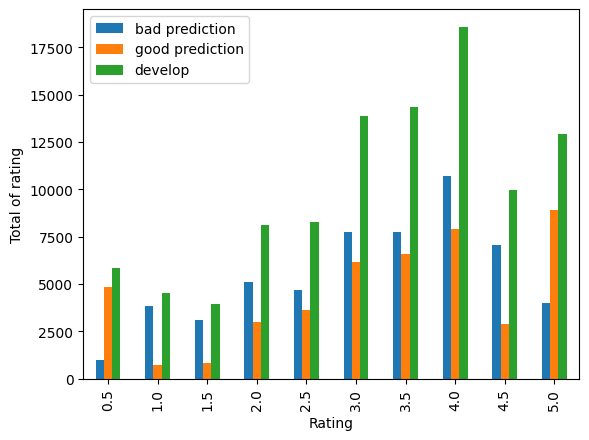

In [7]:
note_values = pd.DataFrame()
note_values["bad prediction"] = devbad["note"].value_counts().sort_index()
note_values["good prediction"] = devGood["note"].value_counts().sort_index()
note_values["develop"] = dev["note"].value_counts().sort_index()

note_values.plot(kind="bar", xlabel="Rating", ylabel="Total of rating") # title="comparaison note",
plt.show()

Text(0, 0.5, 'Nombre de critiques')

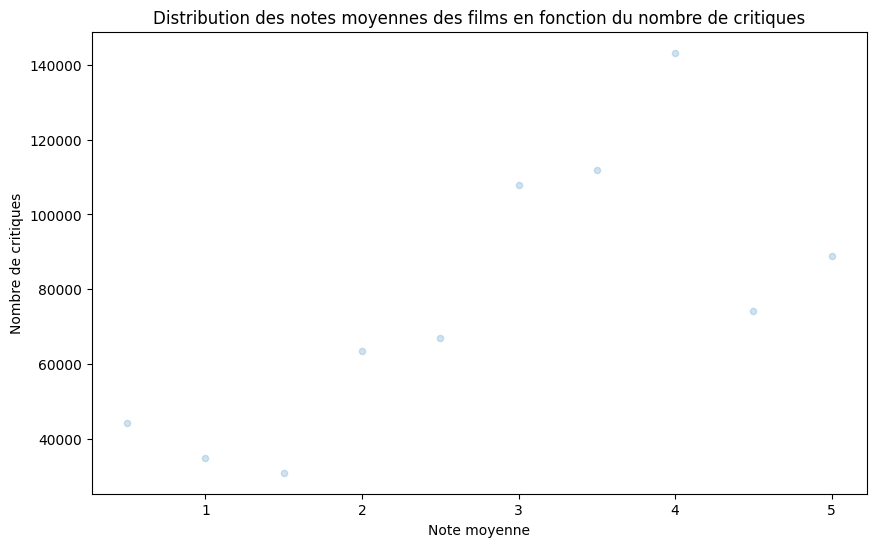

In [8]:
traindev = pd.concat([train, dev])

traindev["lenght"] = traindev["commentaire"].apply(lambda x: len(x))
traindev["class"] = traindev["note"].apply(lambda x: get_rating_class(x))

# remove movies with less than 20 reviews
# traindev = traindev[traindev.groupby("movie")["movie"]].transform("count").ge(20)

traindev = traindev.groupby("note").agg({"lenght": "count", "note": "mean"})

traindev.plot.scatter(y="lenght", x="note", title="Distribution des notes moyennes des films en fonction du nombre de critiques", figsize=(10, 6), alpha=0.2)
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de critiques")

# sns.heatmap(traindev[["class","lenght"]], annot=True)
# traindev[["class","lenght"]]

Text(0, 0.5, 'Nombre de critiques')

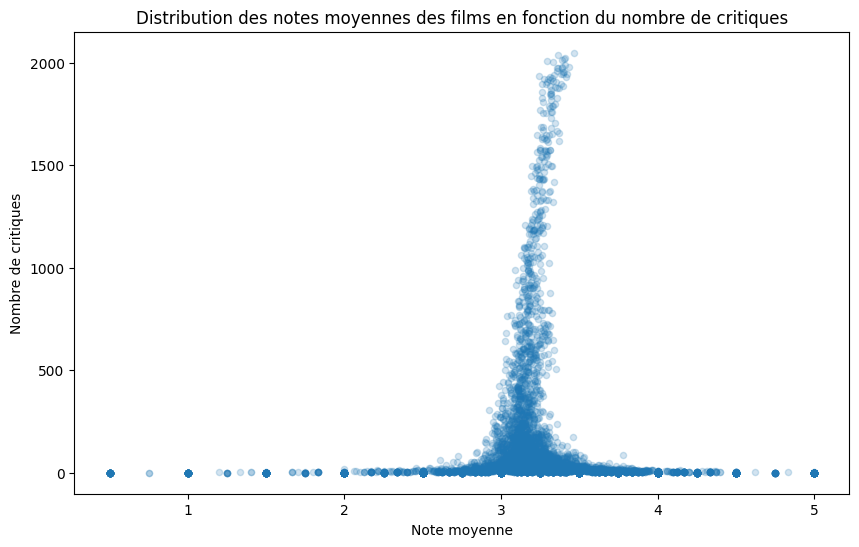

In [9]:
traindev = pd.concat([train, dev])

traindev["lenght"] = traindev["commentaire"].apply(lambda x: len(x))

# remove movies with less than 20 reviews
# traindev = traindev[traindev.groupby("movie")["movie"]].transform("count").ge(20)

traindev = traindev.groupby("lenght").agg({"lenght": "count", "note": "mean"})

traindev.plot.scatter(y="lenght", x="note", title="Distribution des notes moyennes des films en fonction du nombre de critiques", figsize=(10, 6), alpha=0.2)
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de critiques")

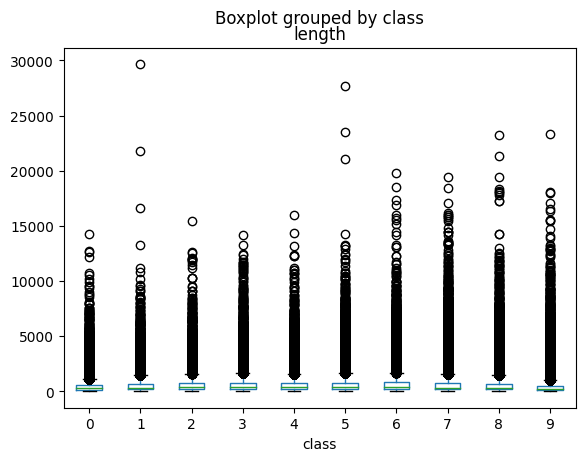

In [10]:
# air_quality.plot.scatter(x="station_london", y="station_paris", alpha=0.5)

# train.plot.bar(x="rating_class", y="length") # , alpha=0.5
# plt.show()


# make a violin plot of the distribution of the ratings
# plt.violinplot(train["note"].values)
# plt.show()

#make a violon plot of lengt of commentaire againt class rating
def plot_length_class(df):

    # df["length"] = df["commentaire"].apply(lambda x: len(x))
    # df["class"] = df["note"].apply(lambda x: get_rating_class(x))
    df.boxplot(column="length", by="class", grid=False) 


plot_length_class(train)

Text(0, 0.5, 'number of reviews (NON-LINEAR SCALE!)')

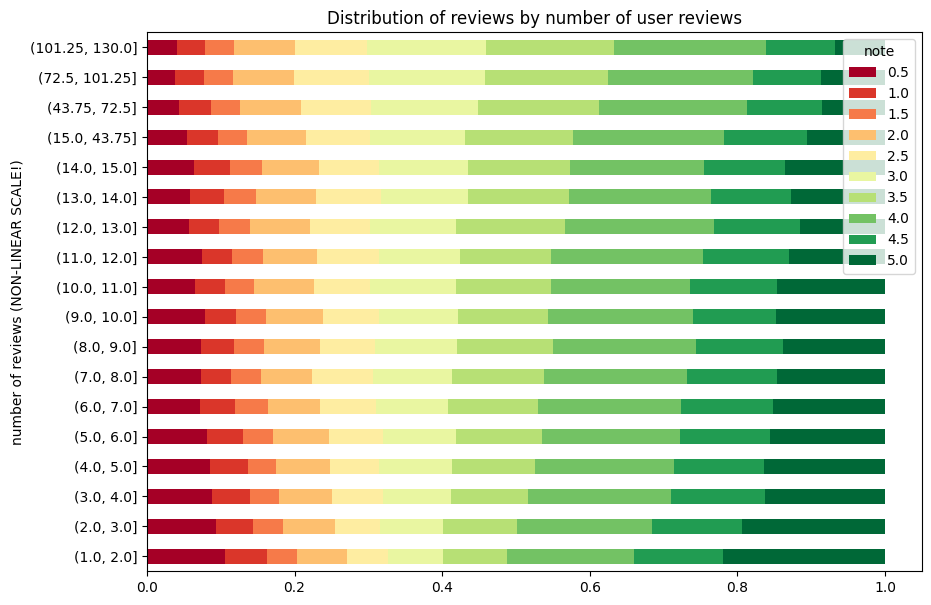

In [13]:
# bin users by the number of reviews they have written into 10 bins
user_subset = pd.concat([train, dev])

bins = np.concatenate((np.linspace(1, 14, 14), np.linspace(15, 130, 5)))

user_subset["bin"] = pd.cut(user_subset.groupby("user_id")["user_id"].transform("count"), bins)

# make a table from the normalized frequency of each rating for each user bin
user_subset = user_subset.groupby("bin").note.value_counts(normalize=True).unstack()

# create stacked horizontal bar plots of the ratings for each user bin using a green-to-red colormap
user_subset.plot.barh( stacked=True, colormap="RdYlGn", figsize=(10, 7)) # title="Distribution of reviews by number of user reviews",
plt.ylabel("number of reviews (NON-LINEAR SCALE!)")

In [12]:
# #Compute a histogram of lenght of commentaire againt class rating
# df = train.copy()
# # bins = np.arange(0, 1000, 64)
# # # add a single bin for comments with length > cutoff
# # bins = np.append(bins, np.inf)

# # Compute a histogram of error rates according to "correct" for each bin of comment length
# df["size"] = df["commentaire"].apply(lambda x: len(x))
# # df["size_bin"] = pd.cut(df["size"], bins=bins)
# df["class"] = df["note"].apply(lambda x: get_rating_class(x))
# df.groupby("class").plot(
#     kind="bar",
#     # title="Accuracy by comment length",
#     xlabel="Comment length",
#     ylabel="Accuracy",
#     figsize=(15, 5),
#     color="green",
#     width=0.9,
# )
